# Batch normalization in physics regression tasks

Typical problems where BN (and dropout for dense layers) help regularizing and speeding up training are classification and segmentation tasks, where the output layer usually is normalized via softmax, and thus returns a relative result (not an absolute numerical quantity). In regression problems on the other hand, BN is more delicate.

This notebook shows that batchnorm (and dropout) can have serious negative impact on regression task with large variance in the dataset. Physics problems often fall in this category. In such cases, batch normalization has to be used with care. In fact, for smaller networks in physics regression tasks ($\lesssim 50$ convolutional layers), it is often easier to not use BN. For larger networks however, training is often not practicable without BN. In such cases, large batch sizes help improving the normalization statistics and convergence can be recovered. However, early training needs to be done with small batch sizes for better convergence. This is demonstrated here.


## Import modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import helper

import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-06-20 16:55:50.798740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 16:55:51.357626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-20 16:55:52.361283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:55:52.380170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Data loading

Load and scale the dataset.

In [2]:
path = 'datasets/dataset1_random.h5'  # data path
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(path)

# Resnet with batchnorm

It is often recommended to use batch normalization (BN) before (some also recommend after) every activation, arguing that the nonlinearity and/or slope of the activation can then be ideally exploited. As explained before, the benefit of BN actually strongly depends on the problem, on the data and also on the network architecture. Our physics regression problem is in fact very sensitive to the statistical errors introduced by the batch statistics in BN which differ from batch to batch (the same holds also for dropout).

We will show, by the example of a lightweight resnet model, how batch normalization deteriorates the network results.

## construct the resnets

We define the same res-net architecture with and without batchnorm.

In [3]:
def create_resnet(in_shape, N_blocks=3, with_BN=True):
    # input
    resnet_input = keras.layers.Input(shape=in_shape)

    x = keras.layers.ZeroPadding1D((1, 2))(resnet_input)  # (5, 2) --> (8, 2)
    x = keras.layers.Conv1D(filters=128, kernel_size=3,
                            strides=1, padding='same')(x)

    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter=128, kernel_size=3, strides=1, with_BN=with_BN)
    x = keras.layers.UpSampling1D()(x)  # data dim.: 8 --> 16

    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter=64, kernel_size=3, strides=1, with_BN=with_BN)
    x = keras.layers.UpSampling1D()(x)  # 16 --> 32

    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter=64, kernel_size=3, strides=1, with_BN=with_BN)
    x = keras.layers.UpSampling1D()(x)  # 32 --> 64

    for i in range(N_blocks):
        x = helper.residual_block(x, N_filter=32, kernel_size=3, strides=1, with_BN=with_BN)

    # in every case, we add a final residual block without batch-norm before the output layer
    x = helper.residual_block(x, N_filter=32, kernel_size=3, strides=1, with_BN=False)

    # output
    resnet_outputs = keras.layers.Conv1D(1, kernel_size=1, padding='same')(x)

    # full model
    resnet_model = Model(inputs=resnet_input,
                        outputs=resnet_outputs, name='resnet_model')
    
    return resnet_model

clear_session()

resnet_BN = create_resnet(in_shape=x_test.shape[1:], N_blocks=3, with_BN=True)
resnet_noBN = create_resnet(in_shape=x_test.shape[1:], N_blocks=3, with_BN=False)

resnet_noBN.summary()

2023-06-20 16:55:53.225643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:55:53.225846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:55:53.225964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "resnet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 2)]       0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 8, 2)        0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_54 (Conv1D)             (None, 8, 128)       896         ['zero_padding1d_1[0][0]']       
                                                                                                  
 conv1d_56 (Conv1D)             (None, 8, 128)       16512       ['conv1d_54[0][0]']   

## ResNet model training

We demonstrate here a batch-size increase schedule, which has a similar effect as learning rate decay (which we apply as well), but offers a better computational efficiency (http://arxiv.org/abs/1711.00489). This can be used in any case, but it is particularly interesting for batch normalization. In later training epochs where the batch size is high, the batch statistics converge towards the statistics of the full dataset which helps the batch-normalized network to recover its accurcay disadvantage from early training with small batchsize.

*Note*: Batch normalization also prevents exploding or vanishing gradients, it usually allows for stable training at higher learning rates than without BN.

In [4]:
# callbacks and training config
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/3, patience=3, verbose=1)

train_kwargs = dict(x=x_train, y=y_train, validation_split=.2,
                    epochs=20, callbacks=[reduce_lr])


# fit the model without BN
resnet_noBN.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
                    loss='mse')

hist_noBN = None  # global history after BS incrase
for i in range(3):  # 3x20 epochs, increase batchsize
    _h = resnet_noBN.fit(batch_size=32*2**i, **train_kwargs)
    if hist_noBN is None:
        hist_noBN = _h
    else:
        for k in hist_noBN.history:
            hist_noBN.history[k] = np.concatenate([hist_noBN.history[k], _h.history[k]])


# fit the model with BN
resnet_BN.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.005),
                  loss='mse')

hist_BN = None  # global history after BS incrase
for i in range(3):  # 3x20 epochs, increase batchsize
    _h = resnet_BN.fit(batch_size=32*2**i, **train_kwargs)
    if hist_BN is None:
        hist_BN = _h
    else:
        for k in hist_BN.history:
            hist_BN.history[k] = np.concatenate([hist_BN.history[k], _h.history[k]])

Epoch 1/20


2023-06-20 16:56:00.690202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-20 16:56:01.707949: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x560b9c84a130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-20 16:56:01.707984: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-20 16:56:01.714022: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-20 16:56:01.872309: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1188/1188 [==============================] - ETA: 0s - loss: 0.0149

2023-06-20 16:56:45.948059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1188/1188 [==============================] - 53s 31ms/step - loss: 0.0149 - val_loss: 0.0061 - lr: 0.0010
Epoch 2/20
1188/1188 [==============================] - 37s 31ms/step - loss: 0.0041 - val_loss: 0.0026 - lr: 0.0010
Epoch 3/20
1188/1188 [==============================] - 37s 31ms/step - loss: 0.0021 - val_loss: 0.0013 - lr: 0.0010
Epoch 4/20
1188/1188 [==============================] - 36s 30ms/step - loss: 0.0017 - val_loss: 0.0020 - lr: 0.0010
Epoch 5/20
1188/1188 [==============================] - 37s 31ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 6/20
1188/1188 [==============================] - 36s 30ms/step - loss: 0.0013 - val_loss: 9.2852e-04 - lr: 0.0010
Epoch 7/20
1188/1188 [==============================] - 36s 30ms/step - loss: 0.0011 - val_loss: 0.0014 - lr: 0.0010
Epoch 8/20
1188/1188 [==============================] - 36s 30ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/20
1188/1188 [==============================] - 36s 30ms/step -

### plot the training and validation losses for the different models

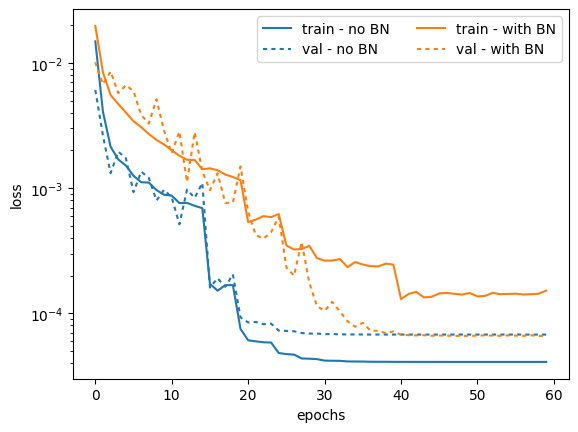

In [8]:
plt.figure()

plt.plot(hist_noBN.history['loss'], color='C0', label='train - no BN')
plt.plot(hist_noBN.history['val_loss'], color='C0', dashes=[2,2], label='val - no BN')

plt.plot(hist_BN.history['loss'], color='C1', label='train - with BN')
plt.plot(hist_BN.history['val_loss'], color='C1', dashes=[2,2], label='val - with BN')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend(ncol=2)
plt.show()

## A note on the loss curve

At late epochs the BN network shows higher training loss than validation loss. This is a result of the different BN statistics at training vs inference time. At inference, the learned, average statistics are used in batchnorm, while at training time each batch is normalized separately.